# Analysis & Visualization of Produced Water Chemistry for Environmental & Agricultural Utilization

## SETUP

In [1]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import sklearn
from wqchartpy import triangle_piper
from sklearn.cluster import KMeans
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
from sklearn.linear_model import LinearRegression
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from branca.element import Element
import branca.colormap as cm
from branca.colormap import linear



C:\Users\darvarir\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# URL of the CSV file
url = 'https://coastal.beg.utexas.edu/soilmoisture2/USGSPWDBv2.3n.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the DataFrame
df


## DATA CLEANING & FILTERING

In [2]:
# Load the data from the CSV files
df1 = pd.read_csv('../data/split_1_USGSPWDBv2.3n.csv', low_memory=False)
df2 = pd.read_csv('../data/split_2_USGSPWDBv2.3n.csv', low_memory=False)
df3 = pd.read_csv('../data/split_3_USGSPWDBv2.3n.csv', low_memory=False)

# Concatenate the dataframes
frames = [df1, df2, df3]
df_merged = pd.concat(frames, ignore_index=True)


# Save the concatenated dataframe to a new CSV file
df_merged.to_csv('../data/df_csv_files/df_merged.csv', index=False)



In [3]:

# List of columns to be removed
columns_to_remove = [
    "IDDB", "SOURCE", "REFERENCE", "LATLONGAPX", "USGSREGION", "BASINCODE", 
    "STATECODE", "COUNTYCODE", "FIELD", "FIELDCODE", "WELLCODE", "TOWNRANGE", 
    "REGDIST", "LOC", "QUAD", "DAY", "DATECOMP", "DATEANALYS", "METHOD", 
    "OPERATOR", "PERMIT", "DFORM", "GROUP", "MEMBER", "AGECODE", "ERA", 
    "PERIOD", "EPOCH", "LAB", "REMARKS", "LITHOLOGY", "POROSITY", "TEMP", 
    "PRESSURE", "SG", "SPGRAV", "SPGRAVT", "RESIS", "RESIST", "PH", "PHT", 
    "EHORP", "COND", "CONDT", "TURBIDITY", "HEM", "MBAS","TDS","TDSCALC", "TSS", "CHARGEBAL", 
    "ACIDITY", "DIC", "DOC", "TOC", "CN", "BOD", "COD", "BENZENE", "TOLUENE", 
    "ETHYLBENZ", "XYLENE", "ACETATE", "BUTYRATE", "FORMATE", "LACTATE", 
    "PHENOLS", "PERC", "PROPIONATE", "PYRUVATE", "VALERATE", "ORGACIDS", 
    "Ar", "CH4", "C2H6", "CO2", "H2", "H2S", "He", "N2", "NH3", "O2", "ALPHA", 
    "BETA", "dD", "H3", "d7Li", "d11B", "d13C", "C14", "d18O", "d34S", 
    "d37Cl", "K40", "d81Br", "Sr87Sr86", "I129", "Rn222", "Ra226", "Ra228", 
    "cull_PH", "cull_MgCa", "cull_KCl", "cull_K5Na", "Ag", "Al", "As", "Au", 
    "B", "BO3", "Be", "Bi", "Cd", "Co", "Cr", "Cs", "Cu", "F", "FeS", "FeAl", 
    "FeAl2O3", "Hg", "I", "Mn", "Mo", "N", "NO2", "NO3", "NO3NO2", "NH4", 
    "TKN", "Ni", "OH", "P", "PO4", "Pb", "Rh", "Rb", "S", "SO3", "HS", "Sb", 
    "Sc", "Se", "Sn", "Ti", "Tl", "U", "V", "W", "Zn"
]


# Remove the specified columns
df_limited_column = df_merged.drop(columns=columns_to_remove, errors='ignore')

# Display the updated merged dataframe
df_limited_column.to_csv('../data/df_csv_files/df_limited_column.csv', index=False)


In [4]:
# Add column "BASIN_CATEGORY" to df_filtered to aid in later filtering

# Define the basin categories
basin_categories = {
    'Anadarko Basin': ['Amarillo Arch', 'Anadarko', 'Anadarko - Chautauqua Platform', 'Anadarko - Southern Oklahoma'],
    'Appalachian Basin': ['Appalachian', 'Black Warrior'],
    'Gulf Coast Basin': ['Arkla', 'Gulf Coast'],
    'Oklahoma Platform Basins': ['Arkoma', 'Arkoma - Chautauqua Platform', 'Central Kansas Uplift', 
                                                'Chautauqua Platform', 'Cherokee', 'Kansas Basins', 'Nemaha Uplift', 
                                                'Sedgwick', 'Southern Oklahoma'],
    'Fort Worth Basin': ['Bend Arch', 'Fort Worth'],
    'Rocky Mountain Basins': ['Big Horn', 'Black Mesa', 'Denver', 'Green River', 'Paradox', 'Piceance', 
                              'Powder River', 'San Juan', 'Uinta', 'Wind River'],
    'Illinois Basin': ['Illinois'],
    'Michigan Basin': ['Michigan'],
    'Permian Basin': ['Palo Duro', 'Permian'],
    'Williston Basin': ['Williston']
}

# Create a reverse mapping from specific basin to category
basin_to_category = {specific: category for category, specifics in basin_categories.items() for specific in specifics}

df_basins_categorized = df_limited_column.copy()

# Map the 'BASIN' column to a new 'BASIN_CATEGORY' column
df_basins_categorized['BASIN_CATEGORY'] = df_basins_categorized['BASIN'].map(basin_to_category)

# Drop rows that don't have a basin category (i.e., not in your list)
df_basins_categorized = df_basins_categorized.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_basins_categorized.to_csv('../data/df_csv_files/df_basins_categorized.csv', index=False)

In [5]:
# Remove rows where TDSUSGS <= 35000 (sea water to eliminate all coalebed methane produced water and also the failing analyses)
df_filtered = df_basins_categorized[df_basins_categorized['TDSUSGS'] > 35000]

# Save the filtered dataframe to a new CSV file
df_filtered.to_csv('../data/df_csv_files/df_filtered_TDS.csv', index=False)



In [6]:
# Fill NaN values in 'KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg' with zeros for calculation
for col in ['KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg']:
    df_filtered[col].fillna(0, inplace=True)

# First, we'll fill NaN values in 'KNa' and 'K' with zeros for the calculation.
df_filtered['KNa'].fillna(0, inplace=True)
df_filtered['K'].fillna(0, inplace=True)

# Apply conditions to calculate 'Na'
# If 'Na' is missing and both 'KNa' and 'K' are present, populate 'Na' with 'KNa' - 'K'
# If 'Na' is missing and 'KNa' is present but 'K' is not, populate 'Na' with 'KNa'

na_mask = df_filtered['Na'].isna()
na_present = df_filtered['Na'] > 0
kna_present = df_filtered['KNa'] > 0
k_present = df_filtered['K'] > 0
k_missing = df_filtered['K'] == 0

df_filtered.loc[k_missing & na_present & kna_present, 'K'] = df_filtered['KNa'] - df_filtered['Na']
df_filtered.loc[na_mask & kna_present & k_present, 'Na'] = df_filtered['KNa'] - df_filtered['K']
df_filtered.loc[na_mask & kna_present & ~k_present, 'Na'] = df_filtered['KNa']

# Remove rows where 'Na' is still missing
df_filtered.dropna(subset=['Na'], inplace=True)

# Remove rows where 'Cl' is missing
df_filtered.dropna(subset=['Cl'], inplace=True)

# Save the updated dataframe 
df_filtered.to_csv('../data/df_csv_files/df_filtered_Na_Cl.csv', index=False)

C:\Users\darvarir\AppData\Local\Temp\ipykernel_19204\1770324562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(0, inplace=True)
C:\Users\darvarir\AppData\Local\Temp\ipykernel_19204\1770324562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['KNa'].fillna(0, inplace=True)
C:\Users\darvarir\AppData\Local\Temp\ipykernel_19204\1770324562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt

In [7]:
#To calculate the molar concentrations from concentrations given in ppm (parts per million) or mg/L,
#these values need to be converted into moles per liter (M). The formula to convert ppm or mg/L to M is:

                #Molarity (M)=Concentration (mg/L)/ Molar Mass (g/mol) 

#This calculation assumes that 1 ppm is equivalent to 1 mg/L. The molar mass of each element or compound (Na, Ca, Cl, SO4, and Mg) 
#is a constant value based on its atomic or molecular weight.

#Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2) which represent likely unnatural combinations
# Convert concentrations from ppm (mg/L) to Molarity (M)
molar_masses = {'Na': 22.99, 'Ca': 40.08, 'Cl': 35.45, 'SO4': 96.06, 'Mg': 24.305}
for element, molar_mass in molar_masses.items():
    df_filtered[element + '_M'] = df_filtered[element] / molar_mass

# Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2)
condition = (df_filtered['Na_M'] > df_filtered['Ca_M']) & \
            (df_filtered['Cl_M'] > df_filtered['SO4_M']) & \
            (df_filtered['Ca_M'] > df_filtered['Mg_M'] / 2)

df_filtered = df_filtered[condition]

# Save the updated dataframe
df_filtered.to_csv('../data/df_csv_files/df_filtered_corrected_elemental_ratios.csv', index=False)



C:\Users\darvarir\AppData\Local\Temp\ipykernel_19204\3226478907.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
C:\Users\darvarir\AppData\Local\Temp\ipykernel_19204\3226478907.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
C:\Users\darvarir\AppData\Local\Temp\ipykernel_19204\3226478907.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [8]:
# Filter out rows where USGS charge balance is not between -10 and +10
df_filtered = df_filtered[df_filtered['chargebalance'].between(-10, 10)]

# Save the updated dataframe
df_filtered.to_csv('../data/df_csv_files/df_filtered_chargebalance.csv', index=False)



In [9]:
# Calculate charge balance
df_filtered['Cations'] = (df_filtered['Na_M'] * 1) + (df_filtered['Ca_M'] * 2) + (df_filtered['Mg_M'] * 2)
df_filtered['Anions'] = (df_filtered['Cl_M'] * 1) + (df_filtered['SO4_M'] * 2)
df_filtered['CalculatedChargeBalance'] = ((df_filtered['Cations'] - df_filtered['Anions']) / (df_filtered['Cations'] + df_filtered['Anions'])) * 100

# Flag discrepancies between calculated charge balance and existing 'chargebalance' column
threshold = 5  # 5% threshold for discrepancy
df_filtered['ChargeBalanceDiscrepancy'] = abs(df_filtered['CalculatedChargeBalance'] - df_filtered['chargebalance']) > threshold

# Save the updated dataframe with discrepancy flags
df_filtered.to_csv('../data/df_csv_files/df_filtered_discrepancy_flags.csv', index=False)

In [10]:
#Replace missing CO3 with 0's
df_filtered['CO3'].fillna(0, inplace=True)

#Replace missing HCO3 with ALKHCO3 where available
df_filtered['HCO3'].fillna(df_filtered['ALKHCO3'], inplace=True)

#Calculate HCO3 if both HCO3 and ALKHCO3 are missing
mask = df_filtered['HCO3'].isna() & df_filtered['ALKHCO3'].isna()
df_filtered.loc[mask, 'HCO3'] = (df_filtered['Cations'] - df_filtered['Anions']) / 61.0702

# Save the updated dataframe with estimated HCO3
df_filtered.to_csv('../data/df_csv_files/df_filtered_estimated_HCO3.csv', index=False)

# Filtered Dataframe Variations

In [11]:
# Create version of df_filtered that drops all columns without a basin category

df_filtered_categorized_basin = df_filtered.copy()

# Drop rows that don't have a basin category 
df_filtered_categorized_basin = df_filtered_categorized_basin.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_filtered_categorized_basin.to_csv('../data/df_csv_files/df_filtered_categorized_basin.csv', index=False)


In [12]:
# Create version of df_filtered with only the most recent sample from each well

# Convert 'DATESAMPLE' to DateTime format for rows where it's available
df_filtered['DATESAMPLE'] = pd.to_datetime(df_filtered['DATESAMPLE'], errors='coerce')

# Split the DataFrame into two: one where DATESAMPLE is available, and one where it's missing
df_with_date = df_filtered.dropna(subset=['DATESAMPLE'])
df_without_date = df_filtered[df_filtered['DATESAMPLE'].isna()]

# For wells with dates, find the index of the most recent sample
idx_with_date = df_with_date.groupby('WELLNAME')['DATESAMPLE'].idxmax()

# For wells without dates, simply take the last occurrence
idx_without_date = df_without_date.groupby('WELLNAME').tail(1).index

# Combine the indices
combined_idx = idx_with_date.tolist() + idx_without_date.tolist()

# Use the combined indices to filter the DataFrame
df_filtered_recent = df_filtered.loc[combined_idx]

# Save the filtered dataframe to a new CSV file
df_filtered_recent.to_csv('../data/df_filtered_recent.csv', index=False)

In [13]:
# Create version of df_filtered_recent that drops all columns without a basin category

df_filtered_recent_categorized_basin = df_filtered_recent.copy()

# Drop rows that don't have a basin category 
df_filtered_recent_categorized_basin = df_filtered_recent_categorized_basin.dropna(subset=['BASIN_CATEGORY'])

# Save the filtered dataframe to a new CSV file
df_filtered_recent_categorized_basin.to_csv('../data/df_csv_files/df_filtered_recent_categorized_basin.csv', index=False)

## ANALYSIS 

In [14]:
#Descriptive Statistics of columns with numerical data
descriptive_stats = df_filtered.describe()
descriptive_stats

,IDUSGS,LATITUDE,LONGITUDE,TIMESERIES,DEPTHUPPER,DEPTHLOWER,DEPTHWELL,ELEVATION,TDSUSGS,chargebalance,...,Sr,ALKHCO3,Na_M,Ca_M,Cl_M,SO4_M,Mg_M,Cations,Anions,CalculatedChargeBalance
count,46568.000000,40456.000000,40693.000000,66.000000,37711.000000,32477.000000,19634.000000,11481.000000,46568.000000,46568.000000,...,4811.000000,706.000000,46568.000000,46568.000000,46568.000000,46568.000000,46568.000000,46568.000000,46568.000000,46568.000000
mean,56730.645164,37.364217,-97.708347,6.000000,6371.373993,6708.026184,7121.064047,1752.774061,162857.364220,-0.026982,...,663.073582,459.366613,2145.184368,245.798266,2757.982086,9.434100,65.293236,2767.367371,2776.850287,-0.025168
std,30943.257029,6.747505,6.275761,3.687818,3267.379543,3263.024529,3299.554336,1515.930308,91366.732881,1.158768,...,915.674409,607.546106,1183.259837,258.133003,1572.139294,15.461988,63.223077,1550.991526,1567.235708,1.785653
min,65.000000,26.022340,-111.140870,1.000000,8.000000,125.000000,100.000000,0.000000,35006.000000,-10.000000,...,0.142090,4.000000,75.685080,0.074850,18.702398,0.000000,0.000000,78.934473,18.702398,-88.904190
25%,31757.750000,31.960900,-102.860840,3.000000,3570.000000,3996.000000,4557.000000,345.000000,84090.000000,0.000000,...,124.980000,100.000000,1182.167247,64.118825,1411.546897,0.382209,22.587945,1436.310987,1432.466251,-0.053417
50%,61977.500000,35.612000,-98.035000,5.000000,6160.000000,6499.000000,6767.500000,1573.000000,147051.500000,0.000000,...,339.000000,230.000000,1979.769682,167.153194,2499.294781,3.216740,49.454845,2512.270360,2513.692187,0.029520
75%,81419.250000,43.498275,-93.150200,8.000000,8888.000000,9140.000000,9210.000000,2546.000000,230184.750000,0.000000,...,900.000000,559.500000,2832.253154,331.094062,3892.806770,11.453675,88.870603,3898.659838,3908.548965,0.167411
max,114811.000000,49.684620,-75.880000,15.000000,22940.000000,23135.000000,23258.000000,9525.000000,528724.000000,10.000000,...,13100.000000,6124.272616,6517.435842,2120.009980,9246.182133,230.605871,1065.783172,9140.344880,9246.182133,86.956821


In [15]:
#Descriptive Statistics of only elements of primary interest
specific_columns_stats = df_filtered[['Li','Na', 'Mg','Ca', 'Cl', 'SO4', 'HCO3']].describe()
specific_columns_stats


,Li,Na,Mg,Ca,Cl,SO4,HCO3
count,2886.000000,46568.000000,46568.000000,46568.000000,46568.000000,46568.000000,46568.000000
mean,39.614413,49317.788612,1586.952093,9851.594495,97770.464964,906.239668,321.442235
std,83.158328,27203.143655,1536.636896,10345.970743,55732.337970,1485.278608,871.633322
min,0.007100,1740.000000,0.000000,3.000000,663.000000,0.000000,-33.126360
25%,5.557500,27178.025000,549.000000,2569.882500,50039.337500,36.715000,61.000000
50%,14.000000,45514.905000,1202.000000,6699.500000,88600.000000,309.000000,162.465000
75%,43.000000,65113.500000,2160.000000,13270.250000,138000.000000,1100.240000,336.102500
max,1730.000000,149835.850000,25903.860000,84970.000000,327777.156600,22152.000000,55266.000000


In [ ]:
#NOT BEING USED IN PROJECT1

#Clustering Analysis-not using this for Project1, maybe for Project2

# Selecting Latitude and Longitude for clustering
X_distance = df_recent_samples[['LATITUDE', 'LONGITUDE']].dropna()

# K-Means clustering
kmeans_distance = KMeans(n_clusters=20)
kmeans_distance.fit(X_distance)

# Adding cluster labels to your dataframe
df_recent_samples.loc[X_distance.index, 'Distance_Cluster'] = kmeans_distance.labels_

# Plotting the clusters
plt.scatter(df_recent_samples['LATITUDE'], df_recent_samples['LONGITUDE'], c=df_recent_samples['Distance_Cluster'], cmap='viridis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Distance Clustering')
plt.show()


# Drop rows where 'LATITUDE' or 'LONGITUDE' is NaN
df_recent_samples = df_recent_samples.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df_recent_samples, geometry=gpd.points_from_xy(df_recent_samples['LONGITUDE'], df_recent_samples['LATITUDE']))

# Create a base map
map = folium.Map(location=[gdf['LATITUDE'].mean(), gdf['LONGITUDE'].mean()], zoom_start=5)

# Instantiate a marker cluster
marker_cluster = MarkerCluster().add_to(map)

# Add points to the map
for idx, row in gdf.iterrows():
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']],
                  popup=f"Cluster: {row['Distance_Cluster']}",
                  icon=folium.Icon(color='blue', icon='info-sign')).add_to(marker_cluster)

# Display the map
map.save('../images/distance_cluster_map.html')

In [ ]:
#NOT BEING USED IN PROJECT1

#Time Series Analysis


# Convert 'DATESAMPLE' to datetime
df_filtered['DATESAMPLE'] = pd.to_datetime(df_filtered['DATESAMPLE'])

# Group by 'WELLNAME' and filter for groups with more than three unique samples
groups = df_filtered.groupby('WELLNAME')
well_groups = {well: group for well, group in groups if group['DATESAMPLE'].nunique() > 3}

# Decide on a reasonable number of plots per figure
plots_per_figure = 10  # Adjust this number based on your preference and screen size
num_wells = len(well_groups)
num_figures = math.ceil(num_wells / plots_per_figure)

# Loop through each subset of wells and create a figure for each
for fig_idx in range(num_figures):
    start_idx = fig_idx * plots_per_figure
    end_idx = start_idx + plots_per_figure
    current_wells = list(well_groups.keys())[start_idx:end_idx]

    # Create figure
    fig, axes = plt.subplots(nrows=min(plots_per_figure, len(current_wells)), ncols=1, figsize=(10, 5 * min(plots_per_figure, len(current_wells))))
    if plots_per_figure > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax_idx, well in enumerate(current_wells):
        data = well_groups[well].drop_duplicates(subset='DATESAMPLE', keep='first')
        data = data.sort_values(by='DATESAMPLE')

        ax = axes[ax_idx]
        ax.plot(data['DATESAMPLE'], data['Na'], marker='o')
        ax.set_title(f'Time Series for {well}')
        ax.set_xlabel('Sampling Date')
        ax.set_ylabel('Sodium Concentration')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
#NOT BEING USED IN PROJECT1

#Test Hypothesis: Li Concentration vs TDS
# Check for NaN values and remove them


data = df_filtered[['Li', 'TDSUSGS']].dropna()

# Perform Spearman's rank correlation test
spearman_corr, spearman_pval = st.spearmanr(data['Li'], data['TDSUSGS'])

print("Spearman's rank correlation test between Li concentration and TDS:")
print("Correlation Coefficient:", spearman_corr)
print("P-value:", spearman_pval)

# Interpret the results
if spearman_pval < 0.05:
    print("There is a statistically significant relationship between Li concentration and TDS.")
else:
    print("There is no statistically significant relationship between Li concentration and TDS.")


In [ ]:
#NOT BEING USED IN PROJECT1 
    
#Test Hypothesis: Li Concentration vs Depth

    
# Check for NaN values and remove them
data = df_filtered[['Li', 'DEPTHUPPER']].dropna()

# Perform Spearman's rank correlation test
spearman_corr, spearman_pval = stats.spearmanr(data['Li'], data['DEPTHUPPER'])

print("Spearman's rank correlation test between Li concentration and Depth:")
print("Correlation Coefficient:", spearman_corr)
print("P-value:", spearman_pval)

# Interpret the results
if spearman_pval < 0.05:
    print("There is a statistically significant relationship between Li concentration and Depth.")
else:
    print("There is no statistically significant relationship between Li concentration and Depth.")

In [ ]:
#Alejando is working on it

# Regression Analysis


# Remove rows where either Li or DEPTWELL is NaN for regression model training
data_for_regression = df_filtered.dropna(subset=['Li', 'DEPTHWELL'])

# Known Li values
X_known = data_for_regression['Li'] 
y_known = data_for_regression['DEPTHWELL']  

# Rows where Li is unknown
unknown_li = df_filtered[df_filtered['Li'].isna() & df_filtered['DEPTHWELL'].notna()]
X_unknown = unknown_li['Li'] 
y_unknown=unknown_li['DEPTHWELL']

# Check for NaN values in X_unknown and replace with 0
X_unknown.fillna(0, inplace=True)

# Create a linear regression model
model = LinearRegression()

# Fit the model with known Li values
model.fit(X_known.values.reshape(-1, 1), y_known.values)  

# Predict Li for known and unknown DEPTHWELL values
X_pred_known = model.predict(y_known.values.reshape(-1, 1))
X_pred_unknown = model.predict(y_unknown.values.reshape(-1, 1))

# Plotting Li vs DEPTHUPPER with regression line and predicted values
plt.figure(figsize=(10, 6))

# Plot known Li values
plt.scatter(X_known, y_known, color='blue', alpha=0.5, label='Known Li Values')

# Plot predicted Li values for known DEPTH
plt.scatter(X_unknown, y_pred, marker='x', color='red', alpha=0.5, label='Predicted Li on Known Data')

# Plot predicted Li values for unknown DEPTH
#plt.scatter(X_unknown, y_pred_unknown, color='green', alpha=0.5, label='Predicted Li on Unknown Data')

# Plot regression line
li_range = np.linspace(X_known.min(), X_known.max(), 100)
depth_regression = model.predict(li_range.reshape(-1, 1))
plt.plot(li_range, depth_regression, color='black', linestyle='-', label='Regression Line')

plt.xlabel('Li Concentration')
plt.ylabel('Depth')
plt.title('Li Concentration vs Depth with Regression Line')
plt.axvline(0, color='black', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis() 
plt.legend()

# Add regression formula to the plot
plt.text(0.1, 0.9, f'Depth = {model.intercept_:.2f} + {model.coef_[0]:.2f} * Li',
         transform=plt.gca().transAxes, fontsize=12)

## VISUALIZATION

Please select basin categories by entering their numbers separated by commas:
1: Anadarko Basin
2: Appalachian Basin
3: Gulf Coast Basin
4: Oklahoma Platform Basins
5: Fort Worth Basin
6: Rocky Mountain Basins
7: Illinois Basin
8: Michigan Basin
9: Permian Basin
10: Williston Basin
Enter the numbers: 1,3,5,9


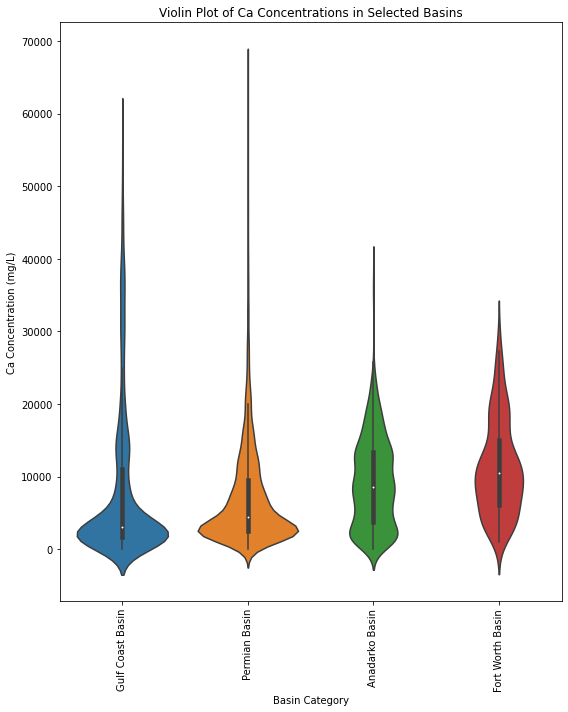

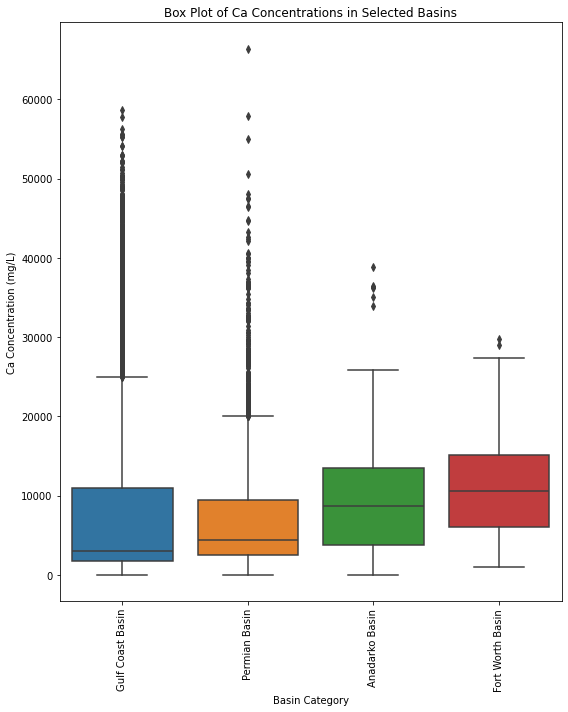

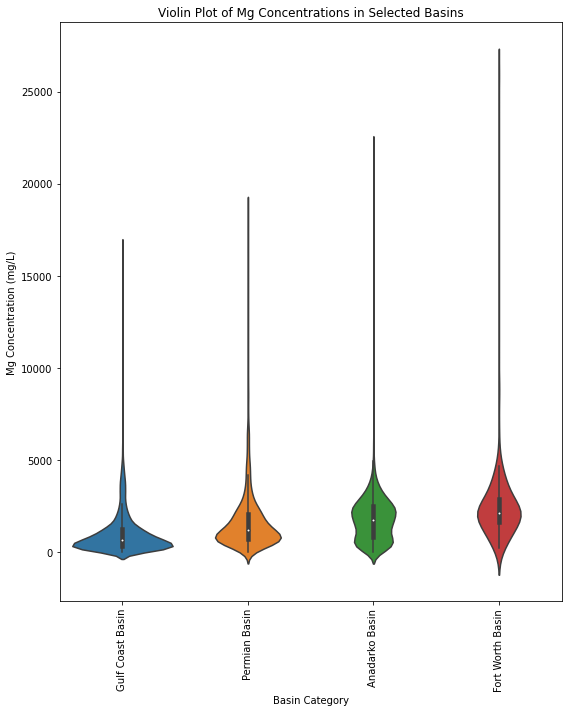

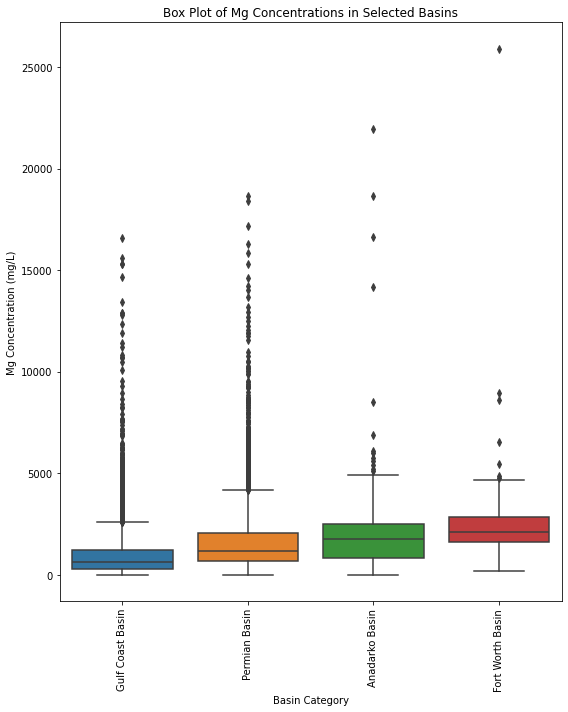

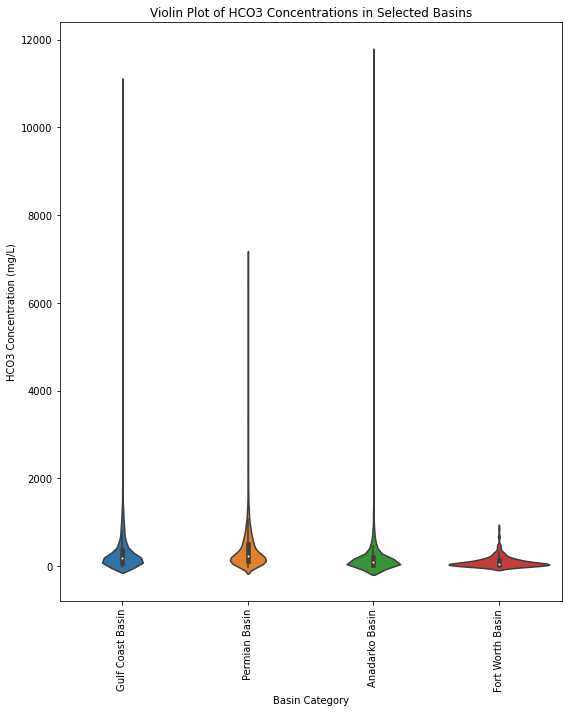

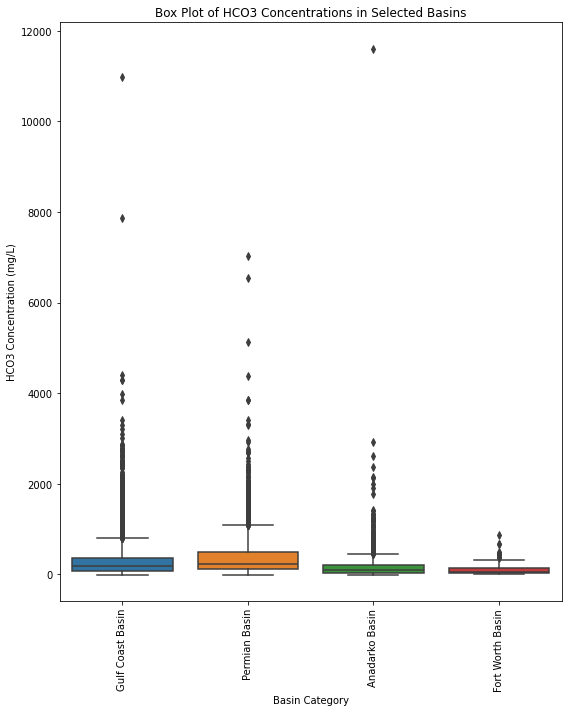

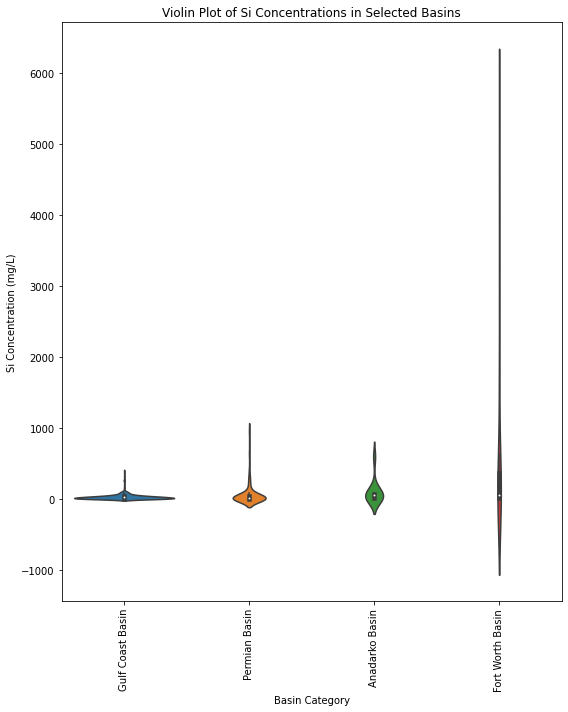

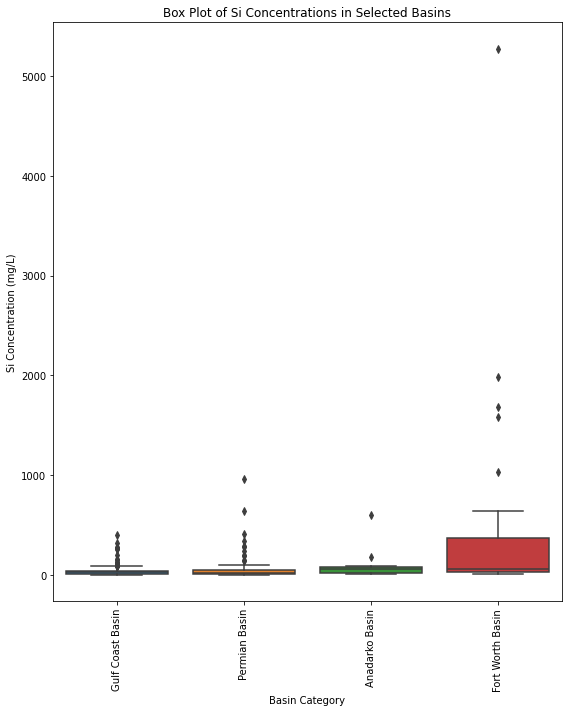

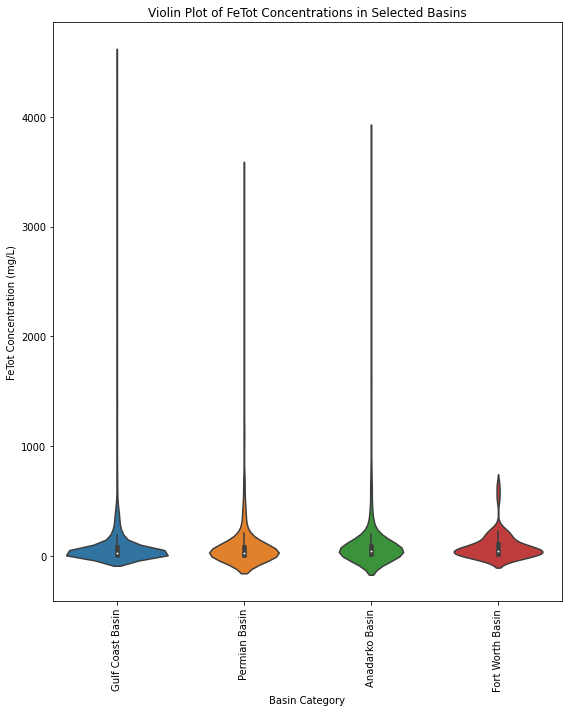

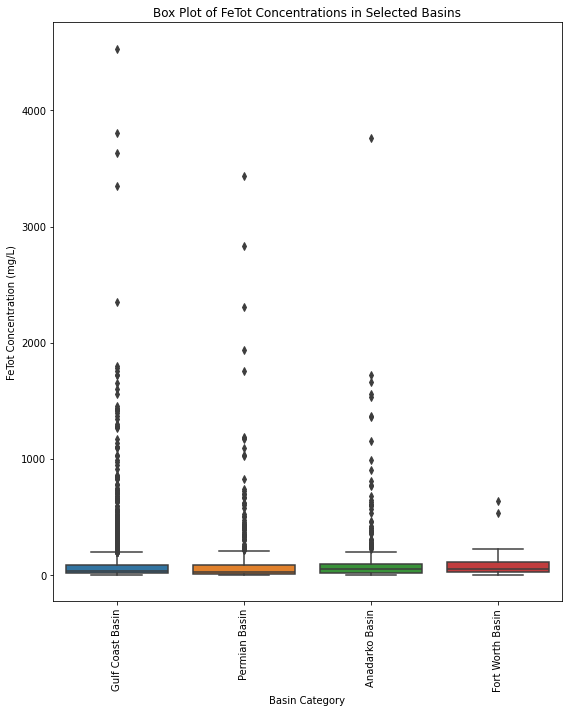

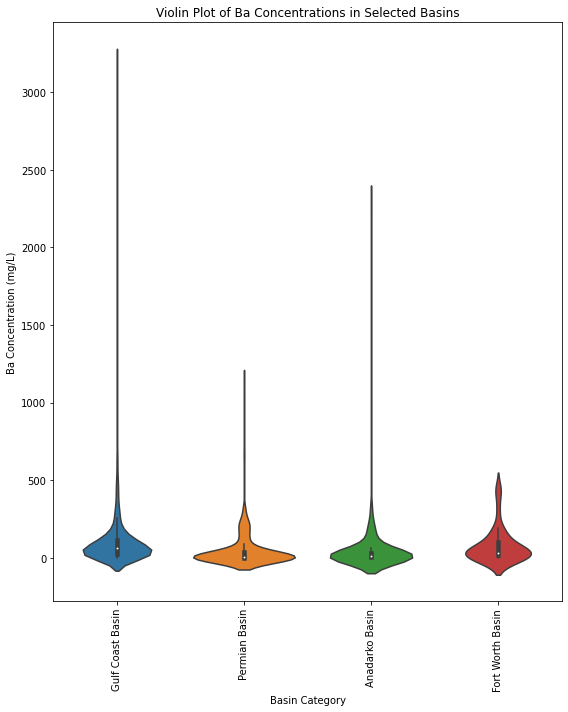

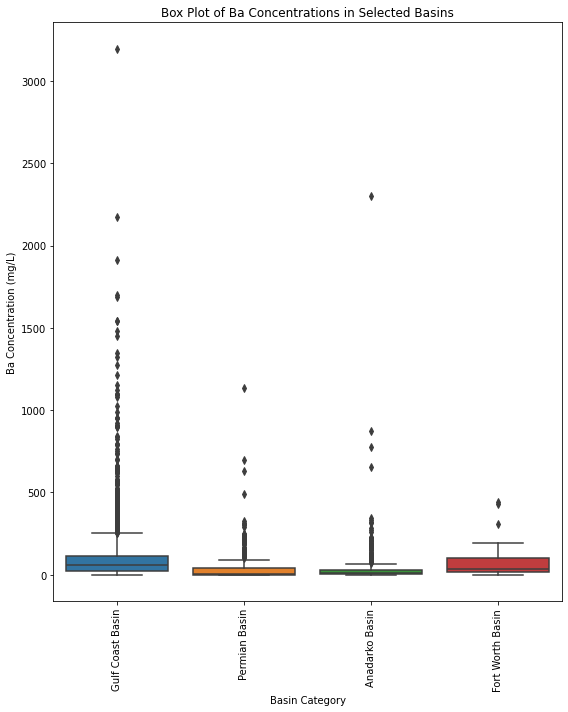

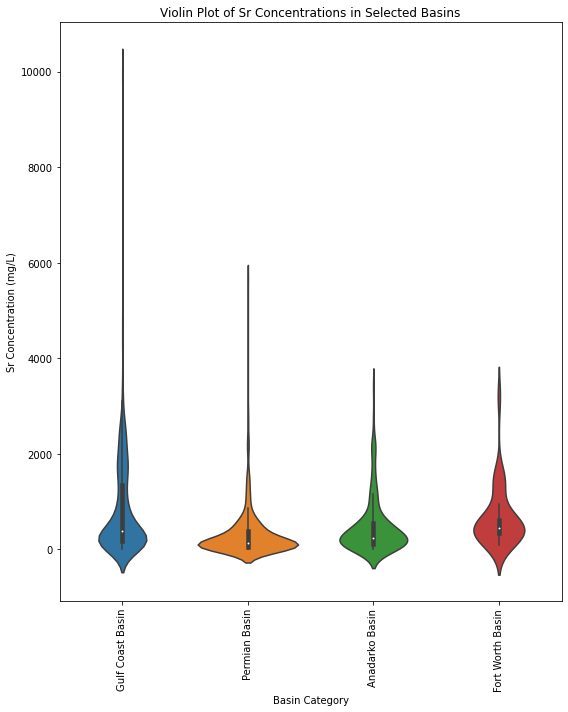

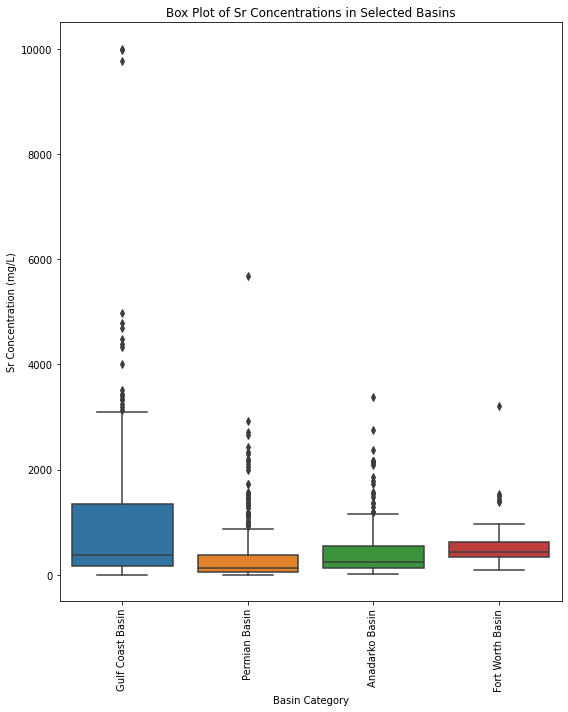

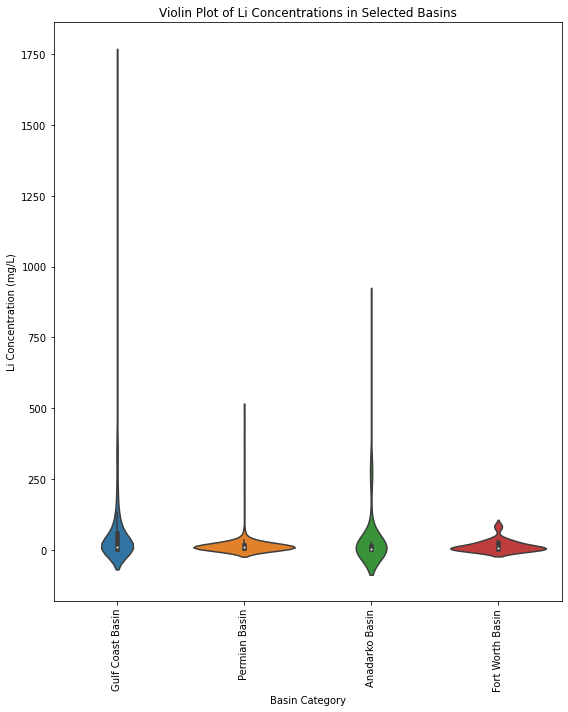

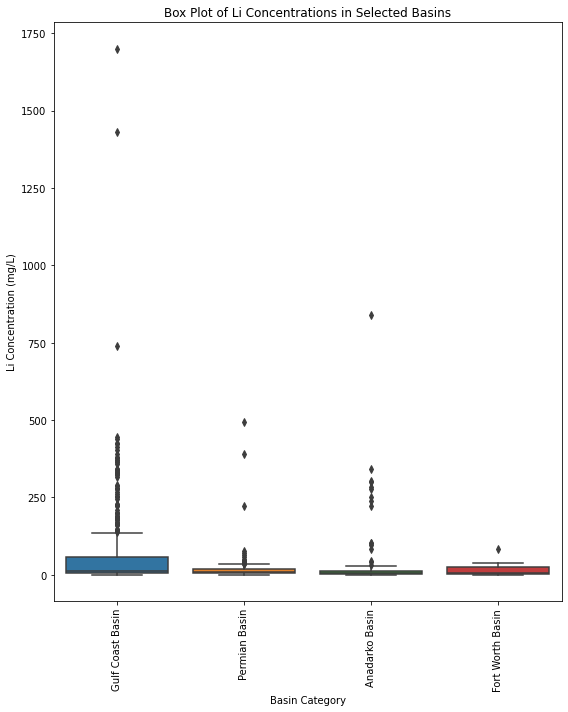

In [17]:

# BOX-PLOT and VIOLIN plot

# Display basin categories and prompt the user to select
basin_categories = {
    1: "Anadarko Basin",
    2: "Appalachian Basin",
    3: "Gulf Coast Basin",
    4: "Oklahoma Platform Basins",
    5: "Fort Worth Basin",
    6: "Rocky Mountain Basins",
    7: "Illinois Basin",
    8: "Michigan Basin",
    9: "Permian Basin",
    10: "Williston Basin"
}

print("Please select basin categories by entering their numbers separated by commas:")
for number, category in basin_categories.items():
    print(f"{number}: {category}")

# Get user input and convert it to a list of selected basins
user_input = input("Enter the numbers: ")
selected_numbers = [int(num.strip()) for num in user_input.split(',')]
selected_basins = [basin_categories[num] for num in selected_numbers if num in basin_categories]


# Filter the dataframe to include only selected basins
df_selected_basins = df_filtered_recent_categorized_basin[df_filtered_recent_categorized_basin['BASIN_CATEGORY'].isin(selected_basins)]

# Determine figure size based on number of basins
fig_width = max(6, len(selected_basins) * 2)
fig_height = 10

# Function to create violin plots with dynamic sizing
def create_violin_plot(df, element, basin_col='BASIN_CATEGORY', fig_width=fig_width, fig_height=fig_height, save_path='../images/'):
    if element not in df.columns:
        print(f"Element '{element}' not found in the dataframe.")
        return
    plt.figure(figsize=(fig_width, fig_height))
    sns.violinplot(x=basin_col, y=element, data=df)
    plt.xticks(rotation=90)
    plt.title(f'Violin Plot of {element} Concentrations in Selected Basins')
    plt.xlabel('Basin Category')
    plt.ylabel(f'{element} Concentration (mg/L)')
    plt.tight_layout()
    violin_plot_filename = save_path + f'ViolinPlot_{element}.png'
    plt.savefig(violin_plot_filename)
    plt.show()
    plt.close()

# Function to create box plots with dynamic sizing
def create_box_plot(df, element, basin_col='BASIN_CATEGORY', fig_width=fig_width, fig_height=fig_height, save_path='../images/'):
    if element not in df.columns:
        print(f"Element '{element}' not found in the dataframe.")
        return
    plt.figure(figsize=(fig_width, fig_height))
    sns.boxplot(x=basin_col, y=element, data=df)
    plt.xticks(rotation=90)
    plt.title(f'Box Plot of {element} Concentrations in Selected Basins')
    plt.xlabel('Basin Category')
    plt.ylabel(f'{element} Concentration (mg/L)')
    plt.tight_layout()
    box_plot_filename = save_path + f'BoxPlot_{element}.png'
    plt.savefig(box_plot_filename)
    plt.show()
    plt.close()

# Elements to plot
elements_to_plot = ["Ca", "Mg", "HCO3", "Si", "FeTot", "Ba", "Sr", "Li"]

# Generate plots for each element in the selected basins
for element in elements_to_plot:
    if element in df_selected_basins.columns:
        create_violin_plot(df_selected_basins, element, save_path='../images/violinplots/')
        create_box_plot(df_selected_basins, element, save_path='../images/boxplots/')
    else:
        print(f"Element '{element}' not found in the dataframe.")

In [18]:
#Clustering Analysis-Lithium Concentration

# Clean DataFrame to remove NaN values
df_recent_samples_li = df_filtered_recent_categorized_basin.dropna(subset=['LATITUDE', 'LONGITUDE', 'Li'])

def assign_cluster(li_concentration):
    if li_concentration <= 20:
        return '<= 20 ppm'  
    elif li_concentration <= 40:
        return '21-40 ppm'
    elif li_concentration <= 60:
        return '41-60 ppm'
    elif li_concentration <= 80:
        return '61-80 ppm'
    else:
        return '> 80 ppm'
    
    
# Apply the function to create a new column 'Li_Cluster'
df_recent_samples_li['Li_Cluster'] = df_recent_samples_li['Li'].apply(assign_cluster)


# Drop rows where 'LATITUDE' or 'LONGITUDE' is NaN
gdf = gpd.GeoDataFrame(
    df_recent_samples_li.dropna(subset=['LATITUDE', 'LONGITUDE', 'Li']),
    geometry=gpd.points_from_xy(df_recent_samples_li['LONGITUDE'], df_recent_samples_li['LATITUDE'])
)

# Initialize the map centered around the mean latitude and longitude
m = folium.Map(location=[gdf['LATITUDE'].mean(), gdf['LONGITUDE'].mean()], zoom_start=5)

# Define a color scheme for the clusters
color_dict = {
    '<= 20 ppm': 'blue',
    '21-40 ppm': 'green',
    '41-60 ppm': 'yellow',
    '61-80 ppm': 'orange',
    '> 80 ppm': 'red'
}
    
# Add points to the map
for _, row in gdf.iterrows():
    cluster_label = row['Li_Cluster']
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,
        color=color_dict[cluster_label],  # This should now work without a KeyError
        fill=True,
        fill_color=color_dict[cluster_label],
        fill_opacity=0.7
    ).add_to(m)
    

# Define the HTML for the legend
legend_html = """
<div id="legend" style="position: fixed; bottom: 10px; left: 10px; padding: 10px; background-color: white; 
    border: 1px solid #bbb; z-index: 9999; font-size: 14px; box-shadow: 0 0 15px rgba(0, 0, 0, 0.2);
    line-height: 18px;">
    <b>Legend</b><br>
    <= 20 ppm&nbsp;<i style="background: blue; width: 18px; height: 18px; display: inline-block;"></i><br>
    21-40 ppm&nbsp;<i style="background: green; width: 18px; height: 18px; display: inline-block;"></i><br>
    41-60 ppm&nbsp;<i style="background: yellow; width: 18px; height: 18px; display: inline-block;"></i><br>
    61-80 ppm&nbsp;<i style="background: orange; width: 18px; height: 18px; display: inline-block;"></i><br>
    > 80 ppm&nbsp;<i style="background: red; width: 18px; height: 18px; display: inline-block;"></i>
</div>
"""

# Create an Element object, and add the HTML code for the legend
legend_element = Element(legend_html)

# Add the legend element to the map
m.get_root().html.add_child(legend_element)

# Save the map to an HTML file
m.save('../images/geomaps/Li_cluster_map.html')



C:\Users\darvarir\AppData\Local\Temp\ipykernel_19204\2759131108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent_samples_li['Li_Cluster'] = df_recent_samples_li['Li'].apply(assign_cluster)


In [19]:
#Lithium Gradient color code for concentrations above 80 mg/L

# Filter the dataframe for lithium concentrations >= 80
df_high_li = df_recent_samples_li[df_recent_samples_li['Li'] >= 80]

# Create a GeoDataFrame for the filtered data
gdf_high_li = gpd.GeoDataFrame(
    df_high_li,
    geometry=gpd.points_from_xy(df_high_li['LONGITUDE'], df_high_li['LATITUDE'])
)

# Initialize the map centered around the mean latitude and longitude of the high concentration data
m = folium.Map(location=[gdf_high_li['LATITUDE'].mean(), gdf_high_li['LONGITUDE'].mean()], zoom_start=5)

# Create a custom color scale from medium red to dark red
max_li = df_high_li['Li'].max()
min_li = 80  # Since we are only considering values >= 80
color_scale = cm.LinearColormap(
    colors=['#ff9999', '#8b0000'],  # medium red to dark red
    index=[min_li, max_li],
    vmin=min_li,
    vmax=max_li
)


# Add points to the map
for _, row in gdf_high_li.iterrows():
    color = color_scale(row['Li'])  
    
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,
        color=color,  
        weight=0,  #this removes the edge
        fill=True,
        fill_color=color,  # This sets the fill color
        fill_opacity=0.7  # This sets the fill opacity
    ).add_to(m)

# Add the color scale to the map
m.add_child(color_scale)

# Save the map to an HTML file
m.save('../images/geomaps/Li_high_concentration_map.html')

In [ ]:
#NOT BEING USED IN PROJECT1

chemicals = ['Na', 'Cl', 'SO4', 'Mg']

# Calculate the correlation matrix using Pearson coefficient
correlation_matrix_pearson = df_filtered[chemicals].corr(method='pearson')

# Alternatively, for Spearman coefficient
# correlation_matrix_spearman = df_filtered[chemicals].corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix (Pearson) for Chemical Constituents')
plt.show()

In [ ]:
#NOT BEING USED IN PROJECT1

chemicals = ['Na', 'Cl', 'SO4', 'Mg']

# Calculate the correlation matrix using Pearson coefficient
correlation_matrix_pearson = df_filtered[chemicals].corr(method='pearson')

# Alternatively, for Spearman coefficient
# correlation_matrix_spearman = df_filtered[chemicals].corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix (Pearson) for Chemical Constituents')
plt.show()

In [ ]:
#NOT BEING USED IN PROJECT1

# Principal Component Analysis (PCA)


# Define the columns to exclude from the PCA plots
exclude_columns = ['IDUSGS','chargebalance','DEPTHLOWER','DEPTHWELL','ELEVATION','TIMESERIES','ALKHCO3','KNa','FeIII','FeII', 'Na_M', 'Ca_M', 'Cl_M', 'SO4_M', 'Mg_M', 'Cations', 'Anions', 'CalculatedChargeBalance', 'ChargeBalanceDiscrepancy']

# Select numerical columns
numerical_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns

# Remove excluded columns
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

# Check for columns with all NaN values and drop them (if necessary)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Replacing NaN values with the min of the column
df_filtered2 = df_filtered.fillna(df_filtered.min())

# Check and handle infinity values
df_filtered2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_filtered2.fillna(df_filtered.mean(), inplace=True)

# Standardize the data: PCA is affected by scale so we need to scale the features in our data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_filtered2[numerical_columns])

# Initialize PCA - uses 2 components for visualization
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
column_names = [f'PCA{i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=column_names)


# Display the amount of variance explained by each component
print(f"Explained variance by component: {pca.explained_variance_ratio_}")

# Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Save the plot as an image
plt.savefig("../images/PCA_Scree_Plot.png")

# Cumulative Explained Variance Plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')

# Save the plot as an image
plt.savefig("../images/Cumulative_Explained_Variance_Plot.png")


pca_two = PCA(n_components=2)
pca_two_result = pca_two.fit_transform(scaled_data)

# PCA Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_two_result[:, 0], pca_two_result[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of First Two Components')
plt.savefig("../images/PCA_Scatter_Plot_First_Two_Components.png")
plt.show()

# Loadings Plot
num_components = pca.n_components_ 
loadings = pca_two.components_.T
loadings_df = pd.DataFrame(data=loadings, columns=['PC1', 'PC2'], index=numerical_columns)

loadings_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Original Variables')
plt.ylabel('Loadings')
plt.title('Loadings Plot')
plt.xticks(rotation=45)

# Save the plot as an image
plt.savefig("../images/PCA_Loadings_Plot.png")


# Biplot
# Run PCA for the first two components for the biplot
pca_two = PCA(n_components=2)
pca_two_result = pca_two.fit_transform(scaled_data)

# Calculate the rescaled loadings for the first two components
loading_scale_factor = 20  # Adjust as necessary to properly scale the arrows
loadings = pca_two.components_.T * np.sqrt(pca_two.explained_variance_) * loading_scale_factor

# Create the biplot
plt.figure(figsize=(10, 8))

# Plot the loadings (arrows) and variable names
for i in range(loadings.shape[0]):  # Ensure we iterate over each row in loadings
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.9, width=0.005, head_width=0.1, head_length=0.2)
    plt.text(loadings[i, 0], loadings[i, 1], numerical_columns[i], color='black', ha='center', va='center', fontsize=12)

# Set the aspect of the plot to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Adjust the plot limits based on the loadings for the first two components
plt.xlim(min(loadings[:, 0]) * 1.2, max(loadings[:, 0]) * 1.2)
plt.ylim(min(loadings[:, 1]) * 1.2, max(loadings[:, 1]) * 1.2)

plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('Biplot with First Two Principal Components')
plt.grid()

# Save the plot as an image
plt.savefig("../images/PCA_Biplot_Scaled.png")
plt.show()